In [37]:
from google.colab import files

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/703_Project/LSTM/

/content/drive/MyDrive/703_Project/LSTM



DISCLAIMER:

To use the embeddings download the file 'glove.6B.100d.txt'
Link:  https://www.kaggle.com/datasets/anindya2906/glove6b?select=glove.6B.100d.txt




**Libraries importation**

In [39]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.losses import mean_squared_error
from sklearn.model_selection import KFold



In [30]:
!pip install codecarbon

**Create combined csv files**





In [ ]:
"""
def process_folder(main_folder_path, group_label):
   Processes all CSV files in a folder and returns a merged DataFrame.
    frames = []  # List to store the DataFrames of each file
    for subdir, dirs, files in os.walk(main_folder_path):
      for filename in files:
        if filename.endswith('.csv'):
            file_path = os.path.join(subdir, filename)
            df = pd.read_csv(file_path)
            df['conversation_id'] = filename.split('.')[0]  # Use file name as ID
            df['group'] = group_label
            df = df[['text', 'conversation_id', 'group']]
            frames.append(df)
    return pd.concat(frames)

# Folder paths for control and patient CSV files
control_main_folder_path = "Control_csv_data_clean"
patient_main_folder_path = "Patient_csv_data_clean"

# Processing files and merging DataFrames
control_df = process_folder(control_main_folder_path, 'control')
patient_df = process_folder(patient_main_folder_path, 'patient')
combined_df = pd.concat([control_df, patient_df])

# Saving the merged DataFrame to a new CSV file
combined_df.to_csv('combined_control_patient_data.csv', index=False)
"""

**Step 1 : Data preprocessing and split**

In [40]:
# load the data
data = pd.read_csv('combined_control_patient_data.csv')
data_df = pd.DataFrame(data) # DataFrame

In [104]:
# Calculer le nombre total de conversations
total_conversations = data_df['conversation_id'].nunique()

# Calculer le nombre de conversations pour chaque groupe
control_conversations = data_df[data_df['group'] == 'control']['conversation_id'].nunique()
patient_conversations = data_df[data_df['group'] == 'patient']['conversation_id'].nunique()

print(f"Nombre total de conversations : {total_conversations}")
print(f"Nombre de conversations du groupe 'control' : {control_conversations}")
print(f"Nombre de conversations du groupe 'patient' : {patient_conversations}")

Nombre total de conversations : 447
Nombre de conversations du groupe 'control' : 158
Nombre de conversations du groupe 'patient' : 289


In [41]:
# Text data cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9']", " ", text) # Remove non-alphanumeric characters
    text = re.sub(r"\s+", " ", text)  # Remove extra white spaces
    return text

# Text cleaning
data_df['text'] = data_df['text'].apply(clean_text)

In [42]:
# Function to calculate sentiment score
def sentiment_score(text):
    analysis = TextBlob(text) # Creating a TextBlob object from the given text
    return analysis.sentiment.polarity  # Returns the sentiment polarity calculated by TextBlob, he polarity is a floating-point score ranging from -1 (negative) to 1 (positive)

# Apply the sentiment score calculation function to each text in the 'text' column of the DataFrame
#The result is stored in a new column 'sentiment' in the DataFrame
data_df['sentiment'] = data_df['text'].apply(sentiment_score)

In [43]:
# Grouping data by conversation_id
conversation_ids = data['conversation_id'].unique() # Extract unique conversation IDs from the data
np.random.shuffle(conversation_ids) # Shuffle the conversation IDs for randomness

# Splitting conversation IDs for training, validation, and testing
train_size = int(0.8 * len(conversation_ids)) # 80 % of data for training
#val_size = int(0.1 * len(conversation_ids)) # 10% of data for validation
test_size = int(0.2 * len(conversation_ids))  # 20% of data for testing

# Assigning conversation IDs to each dataset
train_ids = conversation_ids[:train_size] # IDs for training set
#val_ids = conversation_ids[train_size:train_size + val_size] #IDs for validation set
test_ids = conversation_ids[train_size:] #IDS for test set

# Selecting the training, validation, and test sets based on conversation IDs
train_df = data[data['conversation_id'].isin(train_ids)] # Training data frame
#val_df = data[data['conversation_id'].isin(val_ids)] # Validation data frame
test_df = data[data['conversation_id'].isin(test_ids)] #test data frame


In [44]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=12385) # Initialize tokenizer with a maximum number of words
tokenizer.fit_on_texts(data['text']) # Fit tokenizer on the text data

# Function to tokenize and pad a DataFrame
max_seq_length = 15 # Setting the maximum sequence length for padding
def prepare_data(df):
    sequences = tokenizer.texts_to_sequences(df['text']) # Tokenize the text
    return pad_sequences(sequences, maxlen=max_seq_length) # Return padded sequences


**How to get num_words and max_seq_length**

In [45]:
# Initializing a tokenizer without limiting the number of words
tokenizer = Tokenizer() # Create a new Tokenizer instance
tokenizer.fit_on_texts(data_df['text']) # Fit the tokenizer on the text data

# Calculating the total number of unique words in the dataset
word_count = len(tokenizer.word_index)  # Get the length of the word_index
print(f"Total number of unique words in the dataset : {word_count}") # Print the total number of unique words

text_lengths = [len(text.split()) for text in data_df['text']]
print(f"Mean: {np.mean(text_lengths)}")
print(f"Median: {np.median(text_lengths)}")
print(f"Percentile 90: {np.percentile(text_lengths, 90)}")

Total number of unique words in the dataset : 12385
Mean: 7.460360360360361
Median: 6.0
Percentile 90: 15.0


**Step 2 : Word Embeddings preparation**

In [102]:
# Loading GloVe embeddings
EMBEDDING_DIM = 100  # for GloVe 6B with 100-dimensional vectors
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Preparing the embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Creating the embedding layer using the embedding matrix
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_seq_length,
                            trainable=False)

In [47]:
# control the embedding matrix
print("Embeddingx matrix dimension :", embedding_matrix.shape)

Embeddingx matrix dimension : (12386, 100)


**Coverage Verification**

In [48]:
# Calculating the percentage of words in the tokenizer that are covered by GloVe embeddings
total_words = len(tokenizer.word_index) # Get the total number of unique words in the tokenizer
words_in_glove = sum(1 for word in tokenizer.word_index if word in embedding_index) # Count how many of these words are present in the GloVe embeddings
coverage_percentage = (words_in_glove / total_words) * 100 # Calculate the coverage percentage: the ratio of words in GloVe to the total words in the tokenizer
print(f"Percentage of tokenizer words covered by GloVe : {coverage_percentage}%")
# 89 % --> good coverage

Percentage of tokenizer words covered by GloVe : 89.01897456600727%


**Step 3 : LSTM implementation, training and Cross-Validation Methodology**

In [83]:
from codecarbon import track_emissions

# Initialize fold number and number of folds for cross-validation
#@track_emissions() # track the carbon footprint
#def train_evaluate_model():
fold_no = 1
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True) # Create KFold object with 3 splits and shuffling
  # Initialize early stopping callback
  #early_stopping = EarlyStopping(monitor='val_loss', patience=10)
  # Loop through each fold for cross-validation
for fold_no, (train_indices, test_indices) in enumerate(kfold.split(conversation_ids), start=1): # Extract train and test IDs for the current fold
      # creating an LSTM model and reinitialize it for each fold
      model = Sequential() # Initialize a sequential model
      model.add(embedding_layer)  # Use the previously prepared embedding layer
      model.add(LSTM(64, return_sequences=True))  # First LSTM layer with fewer units and return sequences
      model.add(LSTM(128, return_sequences=False))  # return_sequences=False for the last LSTM layer, interested in a single output (overall sentiment score)
      model.add(Dropout(0.5)) # Add a Dropout layer to prevent overfitting
      model.add(Dense(1, activation='tanh'))  # Sentiment score between -1 and 1
      model.compile(optimizer='adam', loss='mean_squared_error') # adam is a popular choice and the loss function is mean squared error, typical for regression problems

      # Extract train and test IDs for the current fold
      train_ids = conversation_ids[train_indices]
      test_ids = conversation_ids[test_indices]
      #val_ids = conversation_ids[val]

      # Select train and test DataFrame based on the conversation IDs
      train_df = data[data['conversation_id'].isin(train_ids)]
      test_df = data[data['conversation_id'].isin(test_ids)]
      #val_df = data[data['conversation_id'].isin(val_ids)]

      # Prepare data for training and testing
      X_train_padded = prepare_data(train_df)
      y_train = train_df['sentiment'].values

      X_test_padded = prepare_data(test_df)
      y_test = test_df['sentiment'].values

      #X_val_padded = prepare_data(val_df)
      #y_val = val_df['sentiment'].values

      # Model training for the current fold
      print(f'Training for fold {fold_no} ...')
      model.fit(X_train_padded, y_train, epochs=5, batch_size=64)

      # Model Evaluation on the test set
      test_loss = model.evaluate(X_test_padded, y_test)
      print(f'Loss on the test set for the fold {fold_no}: {test_loss}')

      # Increment the fold number
      fold_no = fold_no + 1

    # Return the necessary variables at the end of the function
  #return model, X_train_padded, y_train, X_test_padded, y_test, train_ids, test_ids

#train_evaluate_model() # return informations about carbon footprint



Training for fold 1 ...
Epoch 1/5
998/998 [==============================] - 37s 35ms/step - loss: 0.0262
Epoch 2/5
998/998 [==============================] - 35s 36ms/step - loss: 0.0154
Epoch 3/5
998/998 [==============================] - 35s 35ms/step - loss: 0.0111
Epoch 4/5
998/998 [==============================] - 34s 35ms/step - loss: 0.0088
Epoch 5/5
468/468 [==============================] - 4s 7ms/step - loss: 0.0080
Perte sur l'ensemble de test pour le fold 1: 0.008031357079744339
Training for fold 2 ...
Epoch 1/5
999/999 [==============================] - 36s 34ms/step - loss: 0.0263
Epoch 2/5
999/999 [==============================] - 34s 34ms/step - loss: 0.0154
Epoch 3/5
999/999 [==============================] - 34s 34ms/step - loss: 0.0113
Epoch 4/5
999/999 [==============================] - 35s 35ms/step - loss: 0.0091
Epoch 5/5
467/467 [==============================] - 5s 9ms/step - loss: 0.0075
Perte sur l'ensemble de test pour le fold 2: 0.007450408302247524
Trai

**Dimensions verification**

In [84]:
#  dimensions of various data frame
print(f"Dimensions of X_train_padded: {X_train_padded.shape}")
print(f"Dimensions of y_train: {y_train.shape}")
print(f"Dimensions of X_test_padded: {X_test_padded.shape}")
print(f"Dimensions of y_test: {y_test.shape}")
print(f"Dimensions of train_ids: {train_ids.shape}")
print(f"Dimensions of test_ids: {test_ids.shape}")

Dimensions of X_train_padded: (61559, 15)
Dimensions of y_train: (61559,)
Dimensions of X_test_padded: (17251, 15)
Dimensions of y_test: (17251,)
Dimensions of train_ids: (358,)
Dimensions of test_ids: (89,)


**Step 4 : Model evaluation**

In [103]:
# Predicting sentiments on the test set
pred_sentiment = model.predict(X_test_padded) # Use the model to predict sentiments for the padded test data
pred_sentiment

540/540 [==============================] - 5s 10ms/step


array([[ 0.0237064 ],
       [ 0.5187548 ],
       [ 0.00288085],
       ...,
       [-0.00318567],
       [-0.00530301],
       [ 0.0077187 ]], dtype=float32)

In [86]:
# Calculating regression metrics
pred_sentiment = pred_sentiment.flatten()
mse = mean_squared_error(y_test, pred_sentiment) # Calculate Mean Squared Error between actual and predicted values
mae = mean_absolute_error(y_test, pred_sentiment) # Calculate Mean Absolute Error between actual and predicted values
rmse = np.sqrt(mse) # Calculate Root Mean Squared Error

print(f"MSE(Mean Squared Error): {(mse)}, MAE(Mean Absolute Error): {(mae)}, RMSE(Root Mean Squared Error): {(rmse)}")
#low MSE --> the model, on average, predicts values ​​quite close to the actual values.
#low MAE --> low average error per prediction
#low RMSE --> low dispersion of errors in the model predictions
#the model gives relatively accurate predictions with low errors on the test set.


MSE(Mean Squared Error): 0.008110309951007366, MAE(Mean Absolute Error): 0.04476990069914933, RMSE(Root Mean Squared Error): 0.09005726128816605


**Contextualization of the metrics**

In [87]:
# Calculating the standard deviation of the actual sentiment score
std_dev_sentiment = np.std(data_df['sentiment'])
print(f"Standard deviation of actual sentiment scores: {std_dev_sentiment}")

# Calculating the mean absolute value of the actual sentiment scores
mean_abs_sentiment = np.mean(np.abs(data_df['sentiment']))
print(f"Mean absolute of actual sentiment scores: {mean_abs_sentiment}")

Standard deviation of actual sentiment scores: 0.2202848557326425
Mean absolute of actual sentiment scores: 0.10087772460610742


In [88]:
# Comparing RMSE with the standard deviation
print(f"The RMSE represents { (rmse / std_dev_sentiment) * 100:.2f}% of the standard deviation of the actual scores")
# This indicates how significant the errors of your sentiment prediction model are compared to the variability of the real data
# the errors of your sentiment prediction model are quite significant compared to the variability of the real data

The RMSE represents 40.88% of the standard deviation of the actual scores


In [89]:
# Comparing MSE with the standard deviation
print(f"The MSE represents {(mse / std_dev_sentiment**2) * 100:.2f}% of the variance in actual scores")
# a small part of the variability in sentiment scores is due to your model's prediction errors --> the model is quite precise

The MSE represents 16.71% of the variance in actual scores


In [90]:
# Comparing MAE with the mean absolute
print(f"The MAE represents {(mae / mean_abs_sentiment) * 100:.2f}%  of the absolute average of real scores.")
# the prediction errors, on average, are quite significant compared to the average deviation of the actual scores



The MAE represents 44.38%  of the absolute average of real scores.


**Graphic visualization**

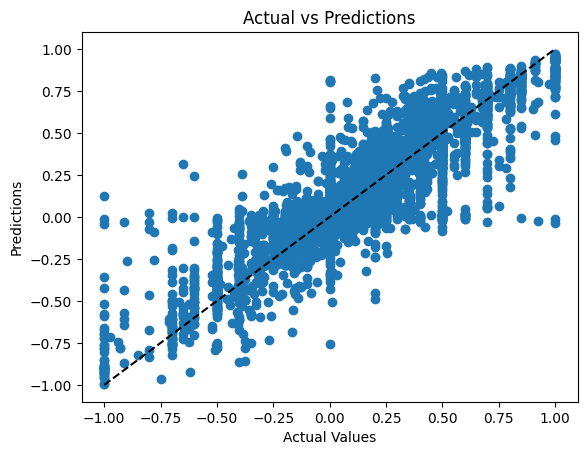

In [92]:
# dispersion graphic
plt.scatter(y_test, pred_sentiment)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Actual vs Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # ideal lign
plt.show()

In [93]:
# Creating a DataFrame to associate predictions with conversations
test_df['predicted_sentiment'] = pred_sentiment.flatten() # Add predicted sentiment scores to the test DataFrame

# Grouping by conversation_id
conversations = test_df.groupby('conversation_id') # Group the DataFrame by conversation_id
evolution_sentiments = {} # Initialize a dictionary to store the sentiment evolution for each conversation

for conversation_id, group in conversations:
    sentiment_debut = group['predicted_sentiment'].iloc[0] # Get the first (starting) sentiment prediction of the conversation
    sentiment_fin = group['predicted_sentiment'].iloc[-1] # Get the last (ending) sentiment prediction of the conversation
    evolution_sentiments[conversation_id] = sentiment_fin - sentiment_debut # Calculate the change in sentiment from start to end and store it in the dictionary



<ipython-input-93-1636333b16e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_sentiment'] = pred_sentiment.flatten() # Add predicted sentiment scores to the test DataFrame


In [94]:
test_df.to_csv('test_df.csv', index="False")

In [95]:
# Initialize variables to accumulate variations
total_variation = {}
total_variation_patient = []
total_variation_control = []
num_conversations_patient = 0
num_conversations_control = 0

for conversation_id, group in conversations:
    # Calculate the sentiment variation for the conversation
    variation = group['predicted_sentiment'].iloc[-1] - group['predicted_sentiment'].iloc[0]
    total_variation[conversation_id] = variation

    # Count the number of conversations for each group
    if group['group'].iloc[0] == 'patient':
        num_conversations_patient += 1
        total_variation_patient.append(variation)
    elif group['group'].iloc[0] == 'control':
        num_conversations_control += 1
        total_variation_control.append(variation)

# Calculate averages
average_variation_patient = np.mean(total_variation_patient)
average_variation_control = np.mean(total_variation_control)

# Print average variations and conversation counts
print(f"Average variation for patients: {average_variation_patient}")
print(f"Average variation for controls: {average_variation_control}")

print("Total Variations by Conversation:", total_variation)
print("Number of Conversations - Patient:", num_conversations_patient)
print("Number of Conversations - Control:", num_conversations_control)


Average variation for patients: -0.1831960529088974
Average variation for controls: -0.02706686407327652
Total Variations by Conversation: {'47-1': -0.5840995, '49-2': -0.41097924, '58-1': -0.009688824, '65-1': -0.3508889, '67-1': -0.16887277, '68-1': 0.7144582, '73-2': 0.014765823, '74-1': -0.49340186, '77-2': -0.7215868, 'Baycrest10347a': -0.55845016, 'Baycrest10599a': -0.5059718, 'Baycrest11752a': -1.005112, 'Baycrest12073a': -1.3213072, 'Baycrest12370a': -1.0142088, 'MSUC01a': -0.32210338, 'MSUC02b': -0.021195753, 'MSUC04b': -0.036746457, 'MSUC06a': -0.027887, 'MSUC07a': -0.17651334, 'UMD04': -0.23425977, 'UMD09': 0.0, 'UMD19': -0.35764694, 'UMD24': -0.5262913, 'adler04a': 0.0067002843, 'adler05a': -0.6711446, 'adler20a': -0.010364662, 'adler22a': 0.049479082, 'kurland01c': 0.034899734, 'kurland01e': -0.344649, 'kurland02b': -0.516475, 'kurland02c': -0.00046306197, 'kurland02f': -0.03297568, 'kurland05a': 0.225034, 'kurland07a': -0.07508856, 'kurland12a': 0.0044457065, 'kurland14b'

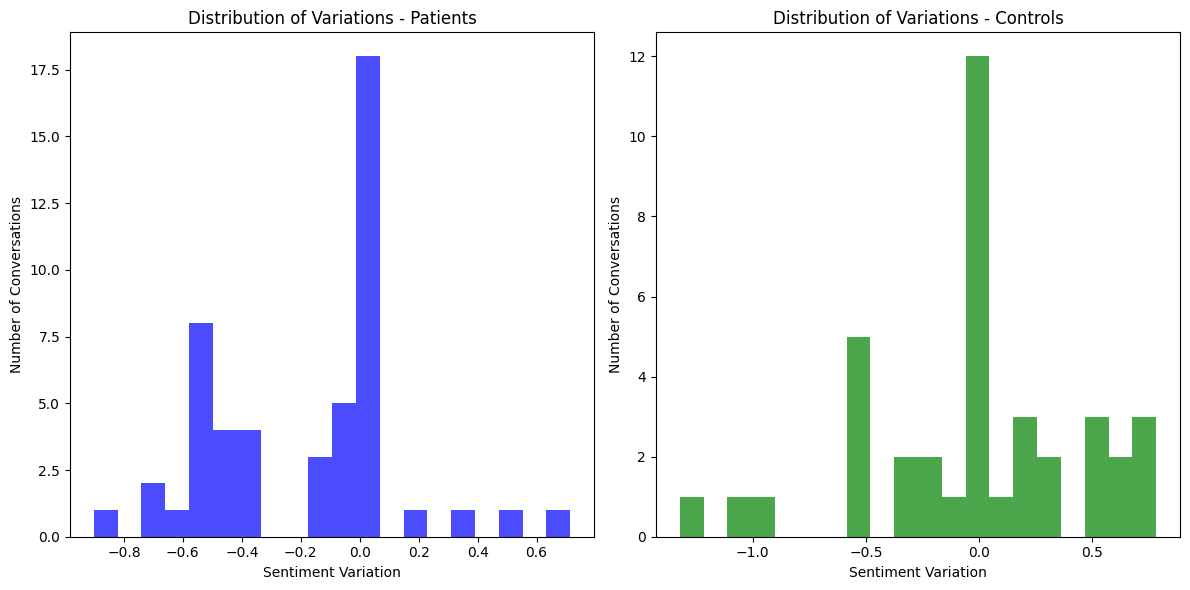

In [96]:
# Histogram of sentiment variations
plt.figure(figsize=(12, 6))

# Histogram for patients
plt.subplot(1, 2, 1)
plt.hist(total_variation_patient, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Variations - Patients")
plt.xlabel("Sentiment Variation")
plt.ylabel("Number of Conversations")

# Histogram for control group
plt.subplot(1, 2, 2)
plt.hist(total_variation_control, bins=20, color='green', alpha=0.7)
plt.title("Distribution of Variations - Controls")
plt.xlabel("Sentiment Variation")
plt.ylabel("Number of Conversations")

plt.tight_layout()
plt.show()

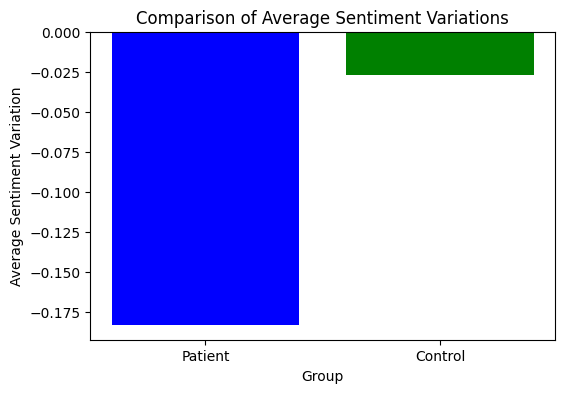

In [97]:
# Bar Chart
# Comparison of the average variations
plt.figure(figsize=(6, 4))
groups = ['Patient', 'Control']
averages = [average_variation_patient, average_variation_control]

# Creating a bar chart to compare the averages
plt.bar(groups, averages, color=['blue', 'green'])
plt.xlabel('Group')
plt.ylabel('Average Sentiment Variation')
plt.title('Comparison of Average Sentiment Variations')
plt.show()

In [98]:
# check the normal distribution
# Shapiro-Wilk to check if both groups follow a normal distribution
# patient group
shapiro_test_patient = stats.shapiro(total_variation_patient)
print(f"Shapiro Test for patient group: Statistic={shapiro_test_patient[0]}, p-value={shapiro_test_patient[1]}")

# control group
shapiro_test_control = stats.shapiro(total_variation_control)
print(f"Shapiro Test for control group : Statistic={shapiro_test_control[0]}, p-value={shapiro_test_control[1]}")


Shapiro Test for patient group: Statistic=0.9246046543121338, p-value=0.003473159857094288
Shapiro Test for control group : Statistic=0.9543459415435791, p-value=0.11516010761260986


In [99]:
#check the homogeneity of variances
from scipy.stats import levene

# Levene's test to check for homogeneity of variances
stat, p_value = levene(total_variation_patient, total_variation_control)

print(f"Levene's Test : Statistic={stat}, p-value={p_value}")

# If p-value > 0.05, it suggests homogeneity of variances

Levene's Test : Statistic=2.391835009621734, p-value=0.12560041539801833


In [100]:
from scipy.stats import ttest_ind

# Performing a t-test for independent samples
t_stat, p_value = ttest_ind(total_variation_patient, total_variation_control)

print(f"T-test for independent samples :  t-Statistic={t_stat}, p-value={p_value}")

#p-value > 0.05 --> the difference between the means of the two groups is not statistically significant
# If p-value > 0.05, it suggests that the difference between the means of the two groups is not statistically significant

T-test for independent samples :  t-Statistic=-1.8128100707244899, p-value=0.07331011409915673


In [101]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U Test
u_statistic, p_value = mannwhitneyu(total_variation_patient, total_variation_control, alternative='two-sided')

print(f"TMann-Whitney U Test: U Statistic={u_statistic}, p-value={p_value}")
#-->  p-value >0.05 not significative statistic difference between the two groups
# If p-value > 0.05, it indicates no statistically significant difference between the two groups

TMann-Whitney U Test: U Statistic=742.5, p-value=0.05505878307953487


**Last function**

In [ ]:
def label_sentiment(score):
    if score > 0:
        return 'POS'
    elif score < 0:
        return 'NEG'
    else:
        return 'NEU'

def process_new_conversations(file_path):
    # Load new data
    new_data = pd.read_csv(file_path)

    # Clean and calculate sentiment
    new_data['text'] = new_data['text'].apply(clean_text)
    new_data['sentiment'] = new_data['text'].apply(sentiment_score)
    new_data['label'] = new_data['sentiment'].apply(label_sentiment)

    # Save the result to a new CSV
    new_data.to_csv('sentiment_labeled_phrases.csv', index=False)

    # Calculate variation between first and last line
    variation_dict = {}
    for conversation_id in new_data['conversation_id'].unique():
        conversation_texts = new_data[new_data['conversation_id'] == conversation_id]
        sentiment_start = conversation_texts['sentiment'].iloc[0]
        sentiment_end = conversation_texts['sentiment'].iloc[-1]
        variation_dict[conversation_id] = sentiment_end - sentiment_start

    return variation_dict

# Usage example:
# variations = process_new_conversations('path_to_new_csv_file.csv')
# print(variations)